In [2]:
import numpy as np
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from time import gmtime, strftime
import warnings
import time
import seaborn as sns
from sklearn.utils import shuffle
import catboost as cb


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [3]:
def eval_f(y_pred, train_data):
    y_true = train_data.label
    y_pred = y_pred.reshape((12, -1)).T
    y_pred = np.argmax(y_pred, axis=1)
    score = f1_score(y_true, y_pred, average='weighted')
    return 'weighted-f1-score', score, True

In [4]:
def submit_result(submit, result, model_name, score):
    now_time = strftime("%Y%m%d%H%M", gmtime())
    submit['recommend_mode'] = result
    #submit['mod_list'] = submit['mod_list'].apply(lambda x: x.strip('[]').split(','))
    #for i, row in submit.iterrows():
    #    if row['mod_list'][0] != '':
    #        row['mod_list'] = map(lambda s : int(s), row['mod_list'])
    #        if row['recommend_mode'] not in row['mod_list']: #and  len(row['mod_list']) != 0:
                #print i,row['mod_list'], row['recommend_mode'], row['sid']
                #submit['recommend_mode'][i] = row['mod_list'][0]
     #           cnt = cnt +1
                #print i,submit['recommend_mode'][i]
    #print("number of correction: ", cnt)
    #submit = submit.drop(['mod_list'], axis=1)
    submit.to_csv('./submit/{}_result_{}_{}.csv'.format(model_name, now_time, round(score,4)), index=False)
    print("done, good luck!!")

In [5]:
def submit_result_D(sb1,sb2,sb3, lgb1,lgb2,lgb3, model_name, score):
    now_time = strftime("%Y%m%d%H%M", gmtime())
    sb1['recommend_mode'] = lgb1
    sb2['recommend_mode'] = lgb2
    sb3['recommend_mode'] = lgb3
    submit = pd.concat([sb1,sb2,sb3], axis=0)  
    submit.to_csv('./submit/{}_result_{}_{}.csv'.format(model_name, now_time, round(score,4)), index=False)
    print("done, good luck!!")

In [20]:
def gen_data(train_x, train_y, val_x, val_y):
    data = train_x.copy()
    #data = pd.concat([train_x, train_y], axis=1)
    data['click_mode'] = train_y
    data0 = data[(data['click_mode'] == 0)]
    data1 = data[(data['click_mode'] == 1)]
    data2 = data[(data['click_mode'] == 2)]
    data3 = data[(data['click_mode'] == 3)]
    data4 = data[(data['click_mode'] == 4)]
    data5 = data[(data['click_mode'] == 5)]
    data6 = data[(data['click_mode'] == 6)]
    data7 = data[(data['click_mode'] == 7)]
    data8 = data[(data['click_mode'] == 8)]
    data9 = data[(data['click_mode'] == 9)]
    data10 = data[(data['click_mode'] == 10)]
    data11 = data[(data['click_mode'] == 11)]
    
    data4 = data4.sample(frac=0.999,axis=0)
    data6 = data6.sample(frac=0.999,axis=0)
    data8 = data8.sample(frac=0.999,axis=0)
    data11 = data11.sample(frac=0.999,axis=0)
    
    data3 = data3.sample(frac=0.999,axis=0)#98
    data10 = data10.sample(frac=0.999,axis=0)
    
    data5 = data5.sample(frac=1,axis=0)#0.6
    data9 = data9.sample(frac=1,axis=0)
    
    data1 = data1.sample(frac=1,axis=0)
    data7 = data7.sample(frac=1,axis=0)
    data0 = data0.sample(frac=1,axis=0)
    #data0x = data0[data0['mode_length'] == 0]
    #data0y = data0[data0['mode_length'] != 0]
    #data0y = data0y.sample(frac=0.7,axis=0)
    data2 = data2.sample(frac=1,axis=0)#0.5
    
    df = pd.concat([data0, data1, data2, data3,
                    data4, data5, data6, data7,
                    data8, data9, data10, data11], axis=0)
    
    y = df['click_mode'].copy()
    x = df.drop(['click_mode'],  axis=1)
    #val = pd.concat([val_x, val_y], axis=1)
    val = val_x.copy()
    val['click_mode'] = val_y
    #val = val.sample(frac=0.6, axis=0)  
    all_data = pd.concat([df, val], axis=0)
    all_y = all_data['click_mode'].copy()
    all_x = all_data.drop(['click_mode'],  axis=1)
    return x,y,all_x,all_y   

In [26]:
# g[0.65, 0.5, 0.5, 0.98, 0.98, 0.5, 0.98, 0.5, 0.98, 0.5, 0.98, 0.98]
# b [0.8, 0.45, 0.45, 0.98, 0.98, 0.6, 0.98, 0.45, 0.98, 0.45, 0.6, 0.98]
#0.7, 0.5, 0.5, 0.98, 0.98, 0.5, 0.98, 0.5, 0.98, 0.5, 0.98, 0.98
def down_sampling(data_all, train_y, sampling_rates=[1,1,1,1,1,1,1,1,1,1,1,1]):
    #data_all = pd.concat([train_x, train_y], axis=1)
    data_all['click_mode'] = train_y
    data = {}
    for mode, rate in enumerate(sampling_rates):
        data[mode] = pd.DataFrame()
        data[mode] = data_all[(data_all['click_mode'] == mode)]
        data[mode] = data[mode].sample(frac=rate, axis=0)
    
    df = pd.concat([data[mode] for mode in range(12)], axis=0)
    df = df.sample(frac=1)
    y = np.array(df['click_mode'])
    x = df.drop(['click_mode'],  axis=1)
    
    return x,y

In [8]:
def f1_weighted(labels, preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

def train_lgb(train_x, train_y, test_x):  #,train_x1, train_y1,
    #kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
    
    train_index = ((train_x['day_time'] <= '2018-11-23'))
    valid_index = (train_x['day_time'] > '2018-11-23') & (train_x['day_time'] < '2018-12-01')
    
    train_x = train_x.drop(['day_time'], axis = 1)
    test_x = test_x.drop(['day_time'], axis = 1)
    
    tr_x1     = train_x[train_index]    #train_x1#
    tr_y1     = train_y[train_index]    #train_y1#
    val_x     = train_x[valid_index]
    val_y     = train_y[valid_index]

    
    
    cate_cols = ['max_dist_mode', 'min_dist_mode', #'max_price_mode','pred_5']#['pred_0','pred_1','cpred_0']#
                'min_price_mode', 'max_eta_mode', 'min_eta_mode',
                 'first_mode','last_mode', 'week', ]
    scores = []
    results = []
 
    for i in range(1):
        lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=41,#41 
        reg_alpha=0, 
        reg_lambda=0.01,
        max_depth=-1, 
        n_estimators=2000, 
        objective='multiclass',
        subsample=0.8, #6
        colsample_bytree=0.8, 
        subsample_freq=1,
        min_child_samples = 50,  
        learning_rate=0.05, 
        random_state=2019, 
        metric="None",
        n_jobs=-1)
        
        tr_x, tr_y, all_train_x, all_train_y = gen_data(tr_x1, tr_y1, val_x, val_y)
        
        eval_set = [(val_x, val_y)]
        lgb_model.fit(
            tr_x, tr_y, eval_set=eval_set,
            eval_metric=f1_weighted,
            categorical_feature=cate_cols,
            verbose=50, early_stopping_rounds=70)
        
        
        def get_weighted_fscore(y_pred, y_true):
            f_score = 0
            for i in range(12):
                yt = y_true == i
                yp = y_pred == i
                f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
                print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
            print(f_score)
            return f_score
        
        val_pred = lgb_model.predict(val_x)
        
        
        
        pred = lgb_model.predict(val_x) 
        df_analysis = pd.DataFrame()
        #df_analysis['sid']   = val_x['sid']
        df_analysis['label'] = val_y
        df_analysis['pred']  = pred
        df_analysis['label'] = df_analysis['label'].astype(int)
        dic_ = df_analysis['label'].value_counts(normalize = True)
        
        val_score = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
        
        scores.append(val_score)
        lgb_model.n_estimators = lgb_model.best_iteration_
        #lgb_model.fit(all_train_x, all_train_y, categorical_feature=cate_cols)
        pred_test = lgb_model.predict_proba(test_x)
        results.append(pred_test)
        
    result = np.argmax(np.mean(results, axis=0), axis=1)  
    print('cv f1-score: ', np.mean(scores))
    return result, np.mean(scores)

In [24]:
def train_lgb_k_fold(train_x, train_y, test_x):
    train_x = train_x.drop(['day_time'], axis = 1)
    test_x = test_x.drop(['day_time'], axis = 1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
    lgb_paras = {
        'objective': 'multiclass',
        'metrics': 'multiclass',
        'learning_rate': 0.1,
        'num_leaves': 41,
        'lambda_l1': 0.01,
        'lambda_l2': 10,
        'num_class': 12,
        'seed': 2019,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4,
    }
    cate_cols = ['pred_0','pred_1','cpred_0']#['max_dist_mode', 'min_dist_mode', #'max_price_mode','pred_5']#
                 #'min_price_mode', 'max_eta_mode', 'min_eta_mode',
                 #'first_mode','last_mode', 'week', ]#
    scores = []
    result_proba = []
    #second_level_train_set = np.zeros((train_x.shape[0],))
    for tr_idx, val_idx in kfold.split(train_x, train_y):
        tr_x, tr_y, val_x, val_y = train_x.iloc[tr_idx], train_y[tr_idx], train_x.iloc[val_idx], train_y[val_idx]
        tr_x, tr_y = down_sampling(tr_x, tr_y)
        #val_x, val_y = down_sampling(val_x, val_y,[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
        train_set = lgb.Dataset(tr_x, tr_y, categorical_feature=cate_cols)
        val_set = lgb.Dataset(val_x, val_y, categorical_feature=cate_cols)
        lgb_model = lgb.train(lgb_paras, train_set,
                              valid_sets=[val_set], early_stopping_rounds=100, num_boost_round=40000, verbose_eval=50, feval=eval_f)
        val_proba = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
        val_pred = np.argmax(val_proba, axis=1)
        val_score = f1_score(val_y, val_pred, average='weighted')
        result_proba.append(lgb_model.predict(
            test_x, num_iteration=lgb_model.best_iteration))
        scores.append(val_score)
    print('cv f1-score: ', np.mean(scores))
    pred_test = np.argmax(np.mean(result_proba, axis=0), axis=1)
    return pred_test, np.mean(scores)

In [10]:
def train_lgb_k_fold_stack(train_x, train_y, test_x):
    train_x = train_x.drop(['day_time'], axis = 1)
    test_x = test_x.drop(['day_time'], axis = 1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
    lgb_paras = {
        'objective': 'multiclass',
        'metrics': 'multiclass',
        'learning_rate': 0.2,
        'num_leaves': 41,
        'lambda_l1': 0.01,
        'lambda_l2': 10,
        'num_class': 12,
        'seed': 2019,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4,
    }
    cate_cols = ['pred_0','pred_1','cpred_0']
    scores = []
    second_level_test_set = []
    second_level_train_set = np.zeros((train_x.shape[0],12),dtype=np.float32)
    for tr_idx, val_idx in kfold.split(train_x, train_y):
        tr_x, tr_y, val_x, val_y = train_x.iloc[tr_idx], train_y[tr_idx], train_x.iloc[val_idx], train_y[val_idx]
        tr_x, tr_y = down_sampling(tr_x, tr_y)
        #val_x, val_y = down_sampling(val_x, val_y,[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
        train_set = lgb.Dataset(tr_x, tr_y, categorical_feature=cate_cols)
        val_set = lgb.Dataset(val_x, val_y, categorical_feature=cate_cols)
        lgb_model = lgb.train(lgb_paras, train_set,
                              valid_sets=[val_set], early_stopping_rounds=70, num_boost_round=4000, verbose_eval=50, feval=eval_f)
        val_proba = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
        val_pred = np.argmax(val_proba, axis=1)
        second_level_train_set[val_idx] = val_proba
        val_score = f1_score(val_y, val_pred, average='weighted')
        second_level_test_set.append(lgb_model.predict(
            test_x, num_iteration=lgb_model.best_iteration))
        scores.append(val_score)
    print('cv f1-score: ', np.mean(scores))
    pred_test = np.argmax(np.mean(second_level_test_set, axis=0), axis=1)
    pred_tr = np.argmax(second_level_train_set, axis=1)
    second_level_test_set = np.mean(second_level_test_set, axis=0)
    return second_level_train_set, pred_tr, second_level_test_set, pred_test

In [11]:
def split_data_city(tr,te,sb):
    test = pd.concat([sb, te], axis=1)
    te1 = test[test['o1'] < 115]
    te2 = test[(test['o1'] > 115)&(test['o1'] < 118)]
    te3 = test[test['o1'] > 118]
    sb1 = te1[['sid']].copy()
    te1 = te1.drop(['sid'],axis=1)
    sb2 = te2[['sid']].copy()
    te2 = te2.drop(['sid'],axis=1)
    sb3 = te3[['sid']].copy()
    te3 = te3.drop(['sid'],axis=1)
    
    tr1 = tr[tr['o1'] < 115]
    tr2 = tr[(tr['o1'] > 115)&(tr['o1'] < 118)]
    tr3 = tr[tr['o1'] > 118]
    return sb1,sb2,sb3,te1,te2,te3,tr1,tr2,tr3

In [12]:
def gen_stacking_data(train_x, train_y, test_x):
    #tr_day = list(train_x['day_time'])
    #te_day = list(test_x['day_time'])
    second_tr = pd.DataFrame()
    second_te = pd.DataFrame()
    for j in range(1):
        j += 2
        s_tr, pred_tr, s_te, pred_test = train_lgb_k_fold_stack(train_x, train_y, test_x)
        s_tr = pd.DataFrame(s_tr)
        s_te = pd.DataFrame(s_te)
        s_tr.columns = [ str(j)+ '_' + 'cp_{}'.format(i) for i in range(12)]
        s_te.columns = [ str(j)+ '_' + 'cp_{}'.format(i) for i in range(12)]
        s_tr['cpred' + '_' + str(j)] = pred_tr
        s_te['cpred' + '_' + str(j)] = pred_test
        second_tr = pd.concat([second_tr, s_tr], axis=1)
        second_te = pd.concat([second_te, s_te], axis=1)
    del train_x, test_x
    #second_tr['day_time'] = tr_day
    #second_te['day_time'] = te_day
    return second_tr, second_te
    

In [18]:
 if __name__ == '__main__':
    train_data = pd.read_csv("./data/train_data.csv")
    #train_data = train_data[train_data['day_time'] >= '2018-10-08']
    train_data['click_mode'] = train_data['click_mode'].apply(lambda x: int(x))
    train_y = np.array(train_data['click_mode'])
    #train_y = train_data['click_mode'].copy()
    train_x = train_data.drop(['click_mode',], axis=1)
    test_x = pd.read_csv("./data/test_data.csv")#11
    #test_x = test_x.drop([],  axis=1) #'
    submit = pd.read_csv("./data/submit.csv") 
    submit = submit.drop(['mod_list'], axis=1)

In [38]:
y1 = np.array(tr1['click_mode'])
#y2 = np.array(tr2['click_mode'])
#y3 = np.array(tr3['click_mode'])
tr1 = tr1.drop(['click_mode',], axis=1)
#tr2 = tr2.drop(['click_mode',], axis=1)
#tr3 = tr3.drop(['click_mode',], axis=1)

In [13]:
second_tr = pd.read_csv("./data/second_trsh01.csv")
second_te = pd.read_csv("./data/second_tesh01.csv")

In [14]:
second_trx = pd.read_csv("./data/second_trsh0x.csv")
second_tex = pd.read_csv("./data/second_tesh0x.csv")

In [15]:
second_trsh = second_trsh.drop(['day_time',], axis=1)
second_tesh = second_tesh.drop(['day_time',], axis=1)

NameError: name 'second_trsh' is not defined

In [16]:
second_trx = pd.concat([second_tr,second_trx], axis=1)
second_tex = pd.concat([second_te,second_tex], axis=1)

In [23]:
second_trx.head()

,0_p_0,0_p_1,0_p_2,0_p_3,0_p_4,0_p_5,0_p_6,0_p_7,0_p_8,0_p_9,0_p_10,0_p_11,pred_0,1_p_0,1_p_1,1_p_2,1_p_3,1_p_4,1_p_5,1_p_6,1_p_7,1_p_8,1_p_9,1_p_10,1_p_11,pred_1,day_time,0_cp_0,0_cp_1,0_cp_2,0_cp_3,0_cp_4,0_cp_5,0_cp_6,0_cp_7,0_cp_8,0_cp_9,0_cp_10,0_cp_11,cpred_0
0,0.054427,0.026944,0.000005,0.021067,0.028333,0.000001,8.504493e-07,0.869205,1.066995e-06,0.000005,0.000008,0.000005,7,0.043756,0.023634,0.000005,0.018145,0.015876,8.366390e-07,0.000002,0.898560,8.536940e-07,0.000004,0.000009,0.000007,7,2018-10-07,0.068843,0.046271,0.029643,0.027286,0.023941,0.013094,0.005697,0.758206,0.000997,0.014237,0.007260,0.004523,7
1,0.173976,0.462319,0.000017,0.092876,0.046116,0.025419,1.992413e-01,0.000016,3.097929e-07,0.000013,0.000003,0.000004,1,0.181952,0.504123,0.000014,0.094853,0.045080,2.392035e-02,0.150001,0.000024,7.334114e-07,0.000022,0.000004,0.000006,1,2018-10-13,0.168519,0.451878,0.037364,0.071804,0.055262,0.038681,0.117990,0.024446,0.001257,0.017946,0.009151,0.005701,1
2,0.062231,0.091938,0.000010,0.032845,0.042634,0.000001,6.027346e-06,0.000013,5.234158e-01,0.246883,0.000016,0.000007,8,0.056912,0.140374,0.000013,0.036218,0.046883,7.020653e-07,0.000009,0.000017,3.843707e-01,0.335178,0.000016,0.000008,8,2018-11-26,0.076212,0.140832,0.013377,0.034363,0.036788,0.005982,0.002636,0.008826,0.356796,0.318778,0.003330,0.002080,8
3,0.034286,0.000011,0.000005,0.013502,0.019052,0.000001,6.179246e-06,0.832507,8.593302e-07,0.000005,0.100616,0.000007,7,0.038791,0.000017,0.000009,0.019066,0.034936,4.133176e-06,0.000009,0.782989,1.594362e-06,0.000008,0.124164,0.000006,7,2018-10-21,0.062585,0.018986,0.030122,0.024991,0.021429,0.013306,0.005789,0.687562,0.001013,0.014467,0.115154,0.004596,7
4,0.195220,0.000010,0.000007,0.025960,0.012906,0.000002,4.656675e-06,0.765869,1.233404e-06,0.000004,0.000014,0.000003,7,0.138900,0.000011,0.000005,0.021333,0.014314,1.496050e-06,0.000001,0.825415,1.283853e-06,0.000006,0.000008,0.000003,7,2018-10-28,0.201605,0.002631,0.004101,0.025047,0.027048,0.001850,0.000827,0.733057,0.000151,0.002006,0.001030,0.000646,7


In [28]:
lgbres, score = train_lgb_k_fold(second_trx, train_y, second_tex)
submit_result(submit, lgbres, 'lgb', score)
#lgb2, score2 = train_lgb_k_fold(second_trgs, y1,second_tegs)
#lgb3, score3 = train_lgb_k_fold(second_trsh, y3,second_tesh)
#score = (score1 + score2 + score3)/3
#submit_result_D(sb1,sb2,sb3, lgb2, lgb1, lgb3,'lgb', score)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's multi_logloss: 0.888509	valid_0's weighted-f1-score: 0.670577
[100]	valid_0's multi_logloss: 0.865302	valid_0's weighted-f1-score: 0.670869
[150]	valid_0's multi_logloss: 0.863731	valid_0's weighted-f1-score: 0.670786
[200]	valid_0's multi_logloss: 0.863791	valid_0's weighted-f1-score: 0.670757
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.865302	valid_0's weighted-f1-score: 0.670869
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's multi_logloss: 0.900209	valid_0's weighted-f1-score: 0.671254
[100]	valid_0's multi_logloss: 0.867966	valid_0's weighted-f1-score: 0.671694
[150]	valid_0's multi_logloss: 0.865092	valid_0's weighted-f1-score: 0.671444
[200]	valid_0's multi_logloss: 0.864981	valid_0's weighted-f1-score: 0.671166
Early stopping, best iteration is:
[101]	valid_0's multi_logloss: 0.867796	valid_0's weighted-f1-score: 0.671719
Training until validation 

In [238]:
second_trbj = pd.read_csv("./data/second_trbj.csv")
second_tebj = pd.read_csv("./data/second_tebj.csv")
second_trsh = pd.read_csv("./data/second_trsh.csv")
second_tesh = pd.read_csv("./data/second_tesh.csv")
second_trgs = pd.read_csv("./data/second_trgs.csv")
second_tegs = pd.read_csv("./data/second_tegs.csv")
second_trbj['click_mode'] = y2
second_trgs['click_mode'] = y1
second_trsh['click_mode'] = y3
second_tr_d = pd.concat([second_trbj,second_trgs,second_trsh], axis=0)
second_te_d = pd.concat([second_tebj,second_tegs,second_tesh], axis=0)
second_tr_d.to_csv('./data/second_trsh_d.csv', index=False)
second_te_d.to_csv('./data/second_tesh_d.csv', index=False)

In [254]:
second_trbj = second_trbj.drop(['click_mode',], axis=1)
second_trsh = second_trsh.drop(['click_mode',], axis=1)
second_trgs = second_trgs.drop(['click_mode',], axis=1)

In [257]:
submit_result_D(sb1,sb2,sb3, lgb2, lgb1, lgb3,'lgb', score)

done, good luck!!


In [253]:
second_tr_d.head()

,0_p_0,0_p_1,0_p_2,0_p_3,0_p_4,0_p_5,0_p_6,0_p_7,0_p_8,0_p_9,0_p_10,0_p_11,pred_0,1_p_0,1_p_1,1_p_2,1_p_3,1_p_4,1_p_5,1_p_6,1_p_7,1_p_8,1_p_9,1_p_10,1_p_11,pred_1,2_p_0,2_p_1,2_p_2,2_p_3,2_p_4,2_p_5,2_p_6,2_p_7,2_p_8,2_p_9,2_p_10,2_p_11,pred_2,3_p_0,3_p_1,3_p_2,3_p_3,3_p_4,3_p_5,3_p_6,3_p_7,3_p_8,3_p_9,3_p_10,3_p_11,pred_3,day_time
0,0.063521,0.092185,0.000057,0.034933,0.081638,0.000007,0.000030,0.000125,0.208854,0.518583,0.000044,0.000023,9,0.042378,0.082386,0.000061,0.016214,0.030390,0.000009,0.000016,0.000047,0.272202,0.556261,0.000027,0.000009,9,0.071603,0.079008,0.000070,0.031312,0.036944,0.000041,0.000055,0.000069,0.251604,0.529209,0.000039,0.000047,9,0.051013,0.065138,0.000047,0.018638,0.030511,0.000003,0.000012,0.000043,0.448510,0.386060,0.000015,0.000010,8,2018-11-26
1,0.100435,0.000078,0.741668,0.040830,0.046701,0.000024,0.000030,0.034420,0.000015,0.000046,0.035723,0.000030,2,0.044820,0.000036,0.857631,0.041134,0.018924,0.000014,0.000005,0.025233,0.000002,0.000014,0.012183,0.000004,2,0.085213,0.000099,0.795073,0.045320,0.028665,0.000018,0.000018,0.023906,0.000006,0.000032,0.021636,0.000014,2,0.063042,0.000083,0.818190,0.037851,0.034649,0.000021,0.000020,0.024327,0.000012,0.000045,0.021735,0.000026,2,2018-11-08
2,0.088905,0.347591,0.295987,0.215927,0.035136,0.000009,0.016340,0.000037,0.000004,0.000037,0.000019,0.000008,1,0.106378,0.347318,0.213742,0.246295,0.058143,0.000028,0.027928,0.000073,0.000006,0.000046,0.000031,0.000013,1,0.098038,0.411012,0.185402,0.251407,0.043956,0.000011,0.010060,0.000046,0.000006,0.000040,0.000016,0.000006,1,0.119018,0.314588,0.232325,0.258539,0.058145,0.000012,0.017261,0.000053,0.000006,0.000033,0.000016,0.000004,1,2018-10-18
3,0.147799,0.063931,0.588528,0.073423,0.034477,0.000020,0.000053,0.000087,0.000006,0.030740,0.060919,0.000016,2,0.120988,0.047610,0.665637,0.029811,0.036431,0.000027,0.000048,0.000047,0.000011,0.052247,0.047128,0.000016,2,0.102034,0.073223,0.650539,0.065138,0.032795,0.000009,0.000041,0.000056,0.000007,0.028297,0.047849,0.000012,2,0.119811,0.055797,0.657135,0.045720,0.028271,0.000015,0.000038,0.000053,0.000005,0.035371,0.057778,0.000007,2,2018-10-25
4,0.124355,0.000111,0.000045,0.091685,0.045553,0.445706,0.292429,0.000037,0.000010,0.000035,0.000015,0.000018,5,0.145287,0.000134,0.000048,0.074586,0.034027,0.408849,0.336893,0.000079,0.000005,0.000055,0.000012,0.000024,5,0.143082,0.000151,0.000074,0.062285,0.044527,0.370505,0.379225,0.000034,0.000007,0.000068,0.000024,0.000020,6,0.116442,0.000095,0.000051,0.102519,0.048516,0.242149,0.490096,0.000049,0.000005,0.000046,0.000010,0.000021,6,2018-10-26


In [239]:
y_d = np.array(second_tr_d['click_mode'])
second_tr_d = second_tr_d.drop(['click_mode',], axis=1)

In [108]:
tr1x=tr1.drop(['min_price', ], axis=1)
te1x=te1.drop(['min_price', ], axis=1)

In [37]:
second_tr['pred_0'] = second_tr['pred_0'].apply(lambda x: int(x))
second_tr['pred_1'] = second_tr['pred_1'].apply(lambda x: int(x))
second_tr['pred_2'] = second_tr['pred_2'].apply(lambda x: int(x))
second_tr['pred_3'] = second_tr['pred_3'].apply(lambda x: int(x))
second_tr['pred_5'] = second_tr['pred_5'].apply(lambda x: int(x))
second_te['pred_0'] = second_te['pred_0'].apply(lambda x: int(x))
second_te['pred_1'] = second_te['pred_1'].apply(lambda x: int(x))
second_te['pred_2'] = second_te['pred_2'].apply(lambda x: int(x))
second_te['pred_3'] = second_te['pred_3'].apply(lambda x: int(x))
second_te['pred_5'] = second_te['pred_5'].apply(lambda x: int(x))

In [40]:
type(second_tr['pred_0'][0])

numpy.int64

In [85]:
second_tr.head()

,0_p_0,0_p_1,0_p_2,0_p_3,0_p_4,0_p_5,0_p_6,0_p_7,0_p_8,0_p_9,0_p_10,0_p_11,pred_0,1_p_0,1_p_1,1_p_2,1_p_3,1_p_4,1_p_5,1_p_6,1_p_7,1_p_8,1_p_9,1_p_10,1_p_11,pred_1,2_p_0,2_p_1,2_p_2,2_p_3,2_p_4,2_p_5,2_p_6,2_p_7,2_p_8,2_p_9,2_p_10,2_p_11,pred_2,3_p_0,3_p_1,3_p_2,3_p_3,3_p_4,3_p_5,3_p_6,3_p_7,3_p_8,3_p_9,3_p_10,3_p_11,pred_3,day_time,5_p_0,5_p_1,5_p_2,5_p_3,5_p_4,5_p_5,5_p_6,5_p_7,5_p_8,5_p_9,5_p_10,5_p_11,pred_5
0,0.033562,0.047144,0.000008,0.022349,0.023047,0.000003,0.000004,0.873864,1.757926e-06,0.000006,0.000007,0.000005,7,0.044344,0.050507,0.000009,0.035109,0.025871,0.000004,0.000002,0.844135,0.000001,0.000006,0.000008,0.000005,7,0.056194,0.053114,0.000014,0.035755,0.024457,0.000005,0.000008,0.830428,2.350842e-06,0.000008,0.000006,0.000010,7,0.047073,0.043507,0.000009,0.027892,0.031986,0.000003,0.000002,0.849509,6.131563e-07,0.000005,0.000008,0.000005,7,2018-10-07,0.040837,0.048200,0.000011,0.031411,0.024484,0.000006,0.000006,0.855020,2.849463e-06,0.000009,0.000005,0.000010,7
1,0.130341,0.520585,0.000017,0.093939,0.077766,0.035163,0.142137,0.000023,1.914481e-06,0.000014,0.000007,0.000007,1,0.131059,0.501161,0.000025,0.092742,0.067975,0.038309,0.168663,0.000024,0.000003,0.000025,0.000005,0.000009,1,0.143977,0.497717,0.000022,0.093092,0.048945,0.030602,0.185598,0.000019,9.879611e-07,0.000015,0.000004,0.000007,1,0.108037,0.546799,0.000019,0.083617,0.064925,0.034502,0.162060,0.000019,9.971085e-07,0.000012,0.000003,0.000006,1,2018-10-13,0.137766,0.517716,0.000023,0.085009,0.049220,0.027040,0.183161,0.000032,1.949927e-06,0.000018,0.000007,0.000008,1
2,0.049892,0.132524,0.000013,0.035263,0.025480,0.000004,0.000012,0.000025,4.238716e-01,0.332889,0.000015,0.000011,8,0.056489,0.131915,0.000015,0.029554,0.031692,0.000002,0.000006,0.000022,0.397685,0.352599,0.000013,0.000008,8,0.051440,0.087051,0.000015,0.029175,0.032766,0.000003,0.000012,0.000020,4.192888e-01,0.380202,0.000014,0.000013,8,0.059624,0.164638,0.000017,0.035616,0.037137,0.000003,0.000017,0.000025,2.909146e-01,0.411998,0.000006,0.000006,9,2018-11-26,0.064366,0.171058,0.000016,0.059308,0.049895,0.000003,0.000016,0.000020,2.830513e-01,0.372248,0.000013,0.000007,9
3,0.042847,0.000017,0.000007,0.022492,0.021508,0.000003,0.000006,0.820962,2.984088e-06,0.000008,0.092140,0.000006,7,0.043479,0.000022,0.000015,0.023530,0.023543,0.000007,0.000013,0.781998,0.000007,0.000011,0.127370,0.000005,7,0.029401,0.000017,0.000008,0.019535,0.023310,0.000002,0.000005,0.827252,2.177640e-06,0.000007,0.100457,0.000004,7,0.027291,0.000022,0.000014,0.022358,0.024525,0.000004,0.000008,0.838425,4.833374e-06,0.000012,0.087331,0.000005,7,2018-10-21,0.039298,0.000018,0.000007,0.025962,0.032515,0.000003,0.000005,0.824782,2.892590e-06,0.000010,0.077393,0.000004,7
4,0.123653,0.000013,0.000005,0.026030,0.019273,0.000002,0.000003,0.831006,5.659521e-07,0.000005,0.000009,0.000002,7,0.142136,0.000022,0.000010,0.027497,0.019931,0.000006,0.000012,0.810355,0.000003,0.000011,0.000010,0.000005,7,0.177270,0.000025,0.000009,0.035786,0.021141,0.000012,0.000012,0.765710,1.628460e-06,0.000011,0.000017,0.000006,7,0.156387,0.000017,0.000009,0.033800,0.031264,0.000003,0.000005,0.778485,2.199086e-06,0.000006,0.000016,0.000005,7,2018-10-28,0.093893,0.000010,0.000005,0.018182,0.015023,0.000002,0.000008,0.872850,8.010360e-07,0.000005,0.000015,0.000006,7


In [81]:
train_y

array([7, 0, 1, ..., 1, 0, 9])

In [57]:
result_lgb, score =train_lgb(second_tr, train_y, second_te)
submit_result(submit, result_lgb, 'lgb', score)

NameError: name 'second_tr' is not defined

In [68]:
s_tr21 = pd.DataFrame(s_tr21)
s_te21 = pd.DataFrame(s_te21)
s_tr21.columns = ['p_{}'.format(i) for i in range(12)]
s_te21.columns = ['p_{}'.format(i) for i in range(12)]
s_tr21['pred'] = pred_tr21
s_te21['pred'] = pred_test21

In [75]:
s_tr21.shape[0]

500000

In [94]:
s_te2 = s_te2.drop(['day_time'], axis = 1)
a = ['p_x{}'.format(i) for i in range(12)]
a.append('pred_x')
s_te2.columns = a

In [98]:
s_te22  = pd.concat([s_te21, s_te2], axis=1)

In [120]:
sb1['pred' + '_' + str(1)] = 0
sb1.head()

,sid,pred_1
0,2193953,0
1,2296423,0
4,2212635,0
9,2189960,0
12,2281854,0


In [34]:
s_tr2.head(10)

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11,pred
0,0.064936,0.079495,0.000096,0.035471,0.068954,0.000059,0.000053,0.000113,0.160410,0.590320,0.000056,0.000036,9
1,0.047631,0.000078,0.805921,0.051170,0.031765,0.000012,0.000017,0.038021,0.000008,0.000038,0.025320,0.000019,2
2,0.059350,0.312222,0.357617,0.166813,0.089756,0.000018,0.014082,0.000050,0.000006,0.000043,0.000024,0.000018,2
3,0.060613,0.045542,0.694834,0.060587,0.025109,0.000016,0.000053,0.000060,0.000019,0.037005,0.076146,0.000016,2
4,0.097660,0.000180,0.000107,0.084640,0.068969,0.294119,0.453977,0.000113,0.000033,0.000092,0.000051,0.000059,6
5,0.020353,0.000117,0.194611,0.022212,0.009782,0.000030,0.000042,0.000067,0.000016,0.752706,0.000039,0.000026,9
6,0.080680,0.000105,0.000053,0.031423,0.000219,0.822646,0.064766,0.000042,0.000006,0.000030,0.000015,0.000017,5
7,0.030837,0.015010,0.856358,0.039914,0.010488,0.000026,0.000028,0.000056,0.000016,0.047226,0.000025,0.000018,2
8,0.024463,0.000067,0.850570,0.028507,0.026359,0.000016,0.000020,0.000049,0.000006,0.069904,0.000027,0.000012,2
9,0.073524,0.000069,0.000039,0.044650,0.000141,0.860880,0.020614,0.000020,0.000003,0.000033,0.000016,0.000011,5


In [ ]:
resx = np.array(result_lgb).T
for line in resx:
        print np.argmax(np.std(line))
        print line

In [65]:
result_lgb, score, imp = train_lgb_time_serie(second_trx, train_y,second_tex)#用来测试特征重要性
submit = submit_result(submit, result_lgb, 'lgb_time', score) 

Training until validation scores don't improve for 50 rounds.
[10]	valid_0's f1_weighted: 0.613923
[20]	valid_0's f1_weighted: 0.651579
[30]	valid_0's f1_weighted: 0.653046
[40]	valid_0's f1_weighted: 0.653523
[50]	valid_0's f1_weighted: 0.654577
[60]	valid_0's f1_weighted: 0.655392
[70]	valid_0's f1_weighted: 0.656345
[80]	valid_0's f1_weighted: 0.657102
[90]	valid_0's f1_weighted: 0.657732
[100]	valid_0's f1_weighted: 0.658032
[110]	valid_0's f1_weighted: 0.658493
[120]	valid_0's f1_weighted: 0.658885
[130]	valid_0's f1_weighted: 0.659427
[140]	valid_0's f1_weighted: 0.659805
[150]	valid_0's f1_weighted: 0.660076
[160]	valid_0's f1_weighted: 0.660442
[170]	valid_0's f1_weighted: 0.660816
[180]	valid_0's f1_weighted: 0.660854
Did not meet early stopping. Best iteration is:
[180]	valid_0's f1_weighted: 0.660854
(0, 0.20230982151379212, 0.4562672909129602, 0.6415320167564332, 0.35402906208718626)
(1, 0.14622506442683975, 0.673741768579492, 0.6129118528027385, 0.747976501305483)
(2, 0.22

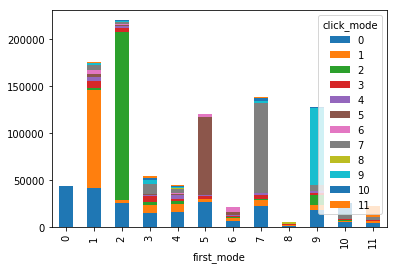

In [68]:
hourDF = tr1.groupby(['first_mode', 'click_mode'])['first_mode'].count().unstack('click_mode').fillna(0)
hourDF.plot(kind='bar', stacked=True)

In [98]:
def f1_weighted(labels, preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

def lgb_sample_select(train_x, train_y, test_x):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
    
    train_index = (train_x['day_time'] <= '2018-11-23')
    valid_index = (train_x['day_time'] > '2018-11-23') & (train_x['day_time'] < '2018-12-01')
    
    train_x = train_x.drop(['day_time'], axis = 1)
    test_x = test_x.drop(['day_time'], axis = 1)
    
    tr_x1     = train_x[train_index]
    tr_y1     = train_y[train_index]
    val_x     = train_x[valid_index]
    val_y     = train_y[valid_index]

    
    
    cate_cols = ['max_dist_mode', 'min_dist_mode', #'max_price_mode',
                 'min_price_mode', 'max_eta_mode', 'min_eta_mode',
                 'first_mode','last_mode', 'week', ]
    scores = []
    result = []
    
    select = pd.DataFrame()
    for i in range(5):
        lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=41,#41 
        reg_alpha=0, 
        reg_lambda=0.01,
        max_depth=-1, 
        n_estimators=2000, 
        objective='multiclass',
        subsample=0.8, #6
        colsample_bytree=0.8, 
        subsample_freq=1,
        min_child_samples = 50,  
        learning_rate=0.1, 
        random_state=2019, 
        metric="None",
        n_jobs=-1)
        
        tr_x, tr_y, all_train_x, all_train_y = gen_data(tr_x1, tr_y1, val_x, val_y)
        
        eval_set = [(val_x, val_y)]
        lgb_model.fit(
            tr_x, tr_y, eval_set=eval_set,
            eval_metric=f1_weighted,
            categorical_feature=cate_cols,
            verbose=50, early_stopping_rounds=50)
        
        
        def get_weighted_fscore(y_pred, y_true):
            f_score = 0
            for i in range(12):
                yt = y_true == i
                yp = y_pred == i
                f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
                print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
            print(f_score)
            return f_score
        
        val_pred = lgb_model.predict(val_x)
        
        
        
        pred = lgb_model.predict(val_x) 
        df_analysis = pd.DataFrame()
        #df_analysis['sid']   = val_x['sid']
        df_analysis['label'] = val_y
        df_analysis['pred']  = pred
        df_analysis['label'] = df_analysis['label'].astype(int)
        dic_ = df_analysis['label'].value_counts(normalize = True)
        
        val_score = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
        
        if(val_score > 0.66395):
            df1 = pd.concat([tr_x, tr_y], axis=1)
            
            select = pd.concat([select, df1], axis=0)
            select.drop_duplicates(keep='first',inplace=True)
    select.to_csv('./data/selected_samples.csv', index=False)       
        

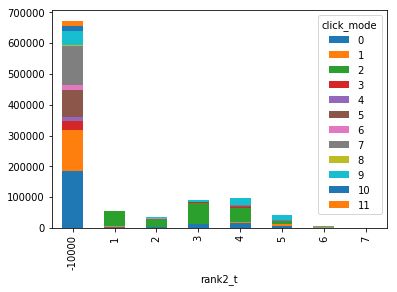

In [71]:
hourDF = tr1.groupby(['rank2_t', 'click_mode'])['rank2_t'].count().unstack('click_mode').fillna(0)
hourDF.plot(kind='bar', stacked=True)

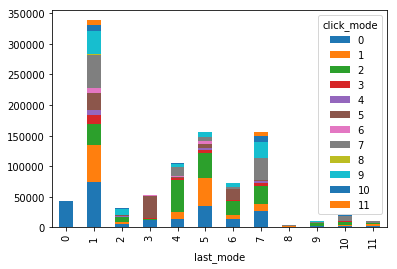

In [72]:
hourDF = tr1.groupby(['last_mode', 'click_mode'])['last_mode'].count().unstack('click_mode').fillna(0)
hourDF.plot(kind='bar', stacked=True)

In [83]:
train_data1.shape[0]

353719

In [59]:
lgb_sample_select(tr1, y1,te1)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's f1_weighted: 0.660105
[100]	valid_0's f1_weighted: 0.662656
[150]	valid_0's f1_weighted: 0.663351
[200]	valid_0's f1_weighted: 0.663552
[250]	valid_0's f1_weighted: 0.663936
[300]	valid_0's f1_weighted: 0.664107
Early stopping, best iteration is:
[285]	valid_0's f1_weighted: 0.664377
(0, 0.20230982151379212, 0.4559170495467528, 0.6665758896151053, 0.3464332892998679)
(1, 0.14622506442683975, 0.6705946337926032, 0.6242686768676867, 0.7243472584856396)
(2, 0.22025388947217714, 0.8751364375888133, 0.8338369765707783, 0.920740162939851)
(3, 0.03152620024816264, 0.08078660643103906, 0.33043478260869563, 0.04601877081441114)
(4, 0.017705450033406508, 0.04523107177974434, 0.2569832402234637, 0.024797843665768194)
(5, 0.09632528395533073, 0.7963071380319748, 0.7298769916618509, 0.8760404280618311)
(6, 0.01577741719958003, 0.2669245647969052, 0.2857142857142857, 0.25045372050816694)
(7, 0.13641309535172283, 0.750741457

In [10]:
def f1_weighted(labels, preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

def select(train_x, train_y):
    lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=41,#41 
        reg_alpha=0, 
        reg_lambda=0.01,
        max_depth=-1, 
        n_estimators=2000, 
        objective='multiclass',
        subsample=0.8, #6
        colsample_bytree=0.8, 
        subsample_freq=1,
        min_child_samples = 50,  
        learning_rate=0.05, 
        random_state=2019, 
        metric="None",
        n_jobs=-1)
    
    train_index = (train_x['day_time'] <= '2018-11-23')
    valid_index = (train_x['day_time'] > '2018-11-23') & (train_x['day_time'] < '2018-12-01')
    train_x = train_x.drop(['day_time'], axis = 1)
    
    tr_x     = train_x[train_index]
    tr_y     = train_y[train_index]
    val_x     = train_x[valid_index]
    val_y     = train_y[valid_index]

    cate_cols = ['max_dist_mode', 'min_dist_mode', 'max_price_mode',
                 'min_price_mode', 'max_eta_mode', 'min_eta_mode',
                 'first_mode', 'last_mode','week']
        
        
    print('Fiting...')
    eval_set = [(val_x, val_y)]
    lgb_model.fit(
        tr_x, tr_y, eval_set=eval_set,
        eval_metric=f1_weighted,
        categorical_feature=cate_cols,
        verbose=10, early_stopping_rounds=50)
    
    pred = lgb_model.predict(val_x) 
    df_analysis = pd.DataFrame()
    #df_analysis['sid']   = val_x['sid']
    df_analysis['label'] = val_y
    df_analysis['pred']  = pred
    df_analysis['label'] = df_analysis['label'].astype(int)
    dic_ = df_analysis['label'].value_counts(normalize = True)
    
    def get_weighted_fscore(y_pred, y_true):
        f_score = 0
        for i in range(12):
            yt = y_true == i
            yp = y_pred == i
            f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
            print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
        print(f_score)
        return f_score
    baseloss = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
    
    imp = pd.DataFrame()
    imp['fea'] = list(val_x.columns)
    imp['imp'] = lgb_model.feature_importances_
    #imp = imp[imp['imp']>0]
    imp = imp.sort_values('imp',ascending = False)
    print('feature number',imp.shape[0])
    n = lgb_model.best_iteration_
    print('base f1 score:',baseloss)
    col =list(imp['fea'])
    col = [i for i in col if i not in cate_cols] 
    
    
    lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=61,#41 
        reg_alpha=0, 
        reg_lambda=0.01,
        max_depth=-1, 
        n_estimators=500, 
        objective='multiclass',
        subsample=0.8, #6
        colsample_bytree=0.8, 
        subsample_freq=1,
        min_child_samples = 50,  
        learning_rate=0.05, 
        random_state=2019, 
        metric="None",
        n_jobs=-1)
    

    def evalsLoss(cols):
        print('Runing...')
        s = time.time()
        colsx = list(set(cols).union(set(cate_cols)))
        val_x1 = val_x[colsx].copy()
        tr_x1 = tr_x[colsx].copy()
        eval_set = [(val_x1, val_y)]
        lgb_model.fit(tr_x1, tr_y, eval_set=eval_set,
                      eval_metric=f1_weighted,
                      categorical_feature=cate_cols,
                      verbose=10, early_stopping_rounds=50)
        pred = lgb_model.predict(val_x1)
        df_analysis = pd.DataFrame()
        df_analysis['label'] = val_y
        df_analysis['pred']  = pred
        df_analysis['label'] = df_analysis['label'].astype(int)
        print(time.time()-s,"s")
        return get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
    
    print('start to choose...')
    all_num = int(len(col)/10)*10
    print('total number of',all_num,'to computer')
    loss = []
    best_num = all_num
    break_num = 0
    for i in range(110,all_num,10):
        loss.append(evalsLoss(col[:i]))
        if loss[-1]>baseloss:
            best_num = i
            baseloss = loss[-1]
        print('the beginning',i,'feature',loss[-1],'scored as',baseloss)
    print('筛选出来最佳特征个数为',best_num,'这下子训练速度终于可以大大提升了')
    return col

In [147]:
res = pd.value_counts(result_lgb)
print res

2     34055
7     22518
1     17860
5     10880
10     3419
0      2158
9      1832
3       558
6       389
11      351
8       255
4        83
dtype: int64


In [102]:
def f1_weighted(labels, preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True
   
def train_lgb_time_serie(train_x, train_y, test_x): 
    
    all_train_x = train_x
    all_train_y = train_y

    train_index = (train_x['day_time'] <= '2018-11-23')
    valid_index = (train_x['day_time'] > '2018-11-23') & (train_x['day_time'] < '2018-12-01')
    train_x = train_x.drop(['day_time'], axis = 1)
    test_x = test_x.drop(['day_time'], axis = 1)
    all_train_x = all_train_x.drop(['day_time'], axis = 1)
    
    
    tr_x     = train_x[train_index]
    tr_y     = train_y[train_index]
    val_x     = train_x[valid_index]
    val_y     = train_y[valid_index]

    
    
    
    cate_cols = ['pred_0','pred_1','cpred_0']
    
    lgb_model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        num_leaves=41,#41 
        reg_alpha=0, 
        reg_lambda=0.01,
        max_depth=-1, 
        n_estimators=100, 
        objective='multiclass',
        subsample=0.8, #6
        colsample_bytree=0.8, 
        subsample_freq=1,
        min_child_samples = 50,  
        learning_rate=0.2, 
        random_state=2019, 
        metric="None",
        n_jobs=-1)
    
    
    
    eval_set = [(val_x, val_y)]
    lgb_model.fit(
        tr_x, tr_y, eval_set=eval_set,
        eval_metric=f1_weighted,
        categorical_feature=cate_cols,
        verbose=10, early_stopping_rounds=50)
    
    
    pred = lgb_model.predict(val_x) 
    df_analysis = pd.DataFrame()
    #df_analysis['sid']   = val_x['sid']
    df_analysis['label'] = val_y
    df_analysis['pred']  = pred
    df_analysis['label'] = df_analysis['label'].astype(int)
    dic_ = df_analysis['label'].value_counts(normalize = True)
    
    def get_weighted_fscore(y_pred, y_true):
        f_score = 0
        for i in range(12):
            yt = y_true == i
            yp = y_pred == i
            f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
            print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
        print(f_score)
        return f_score
    score = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
    
    imp = pd.DataFrame()
    imp['fea'] = list(val_x.columns)
    imp['imp'] = lgb_model.feature_importances_ 
    imp = imp.sort_values('imp',ascending = False)
    
    print(lgb_model.best_iteration_)
    lgb_model.n_estimators = lgb_model.best_iteration_
    #lgb_model.fit(all_train_x, all_train_y, categorical_feature=cate_cols)
    print('fit over')
    pred_test = lgb_model.predict(test_x)
    return pred_test, score, imp
    


In [154]:
train_x = train_data.drop(['day_time','week'],axis =1)

train_x.head()
train_x = train_x.loc[0:30000]
a = list(train_x.corrwith(train_x.click_mode).index)
cor_f = pd.DataFrame()
cor_f['fea'] =  a
cor_f['val'] =  abs(train_x.corrwith(train_x.click_mode).values)
print cor_f.sort_values('val',ascending = False)



                fea       val
1        click_mode  1.000000
172            fm_O  0.640902
95       first_mode  0.640898
52       mode_7_dis  0.407287
53       mode_7_eta  0.406561
54           rank_7  0.406467
51        mode_7_pr  0.406464
89    max_dist_mode  0.312223
62       mode_9_dis  0.278280
63       mode_9_eta  0.277675
61        mode_9_pr  0.277606
64           rank_9  0.277594
26        mode_2_pr  0.243237
29           rank_2  0.243235
28       mode_2_eta  0.243084
27       mode_2_dis  0.242443
65            t*d_9  0.228915
55            t*d_7  0.228136
67      mode_10_dis  0.219395
68      mode_10_eta  0.219091
66       mode_10_pr  0.219054
69          rank_10  0.219049
86         mean_eta  0.212682
85          min_eta  0.199715
84          max_eta  0.197451
70           t*d_10  0.188711
76         max_dist  0.185831
78        mean_dist  0.181788
77         min_dist  0.175519
80        max_price  0.173600
4         time_diff  0.172313
88      mode_length  0.161333
45        

In [ ]:
sumbit

In [33]:
train_x.head()

,pid,mode_1_pr,mode_1_dis,mode_1_eta,mode_2_pr,mode_2_dis,mode_2_eta,mode_3_pr,mode_3_dis,mode_3_eta,mode_4_pr,mode_4_dis,mode_4_eta,mode_5_pr,mode_5_dis,mode_5_eta,mode_6_pr,mode_6_dis,mode_6_eta,mode_7_pr,mode_7_dis,mode_7_eta,mode_8_pr,mode_8_dis,mode_8_eta,mode_9_pr,mode_9_dis,mode_9_eta,mode_10_pr,mode_10_dis,mode_10_eta,mode_11_pr,mode_11_dis,mode_11_eta,max_dist,min_dist,std_dist,std_price,max_eta,min_eta,std_eta,max_dist_mode,min_dist_mode,max_price_mode,min_price_mode,max_eta_mode,min_eta_mode,first_mode,last_mode,second_mode,day-time,month,vac,week,hour,subway_zone,time_zone,o1,o2,d1,d2,d1-o1,d2-o2,svd_fea_0,svd_fea_1,svd_fea_2,svd_fea_3,svd_fea_4,svd_fea_5,svd_fea_6,svd_fea_7,svd_fea_8,svd_fea_9,svd_fea_10,svd_fea_11,svd_fea_12,svd_fea_13,svd_fea_14
0,-1.0,-1000000,-1000000,-1000000,30,521,167,0,453,103,210,453,109,0,404,367,0,411,124,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,30,521,136,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,5219.0,4046.0,467.713825,750.000000,3672.0,1035.0,914.260433,2,5,4,3,5.0,3.0,9,5,5,2018-11-02,1,0,5,17,1,2,116.29,39.97,116.32,39.96,3.0,-1.0,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
1,210736.0,30,1124,357,-1000000,-1000000,-1000000,0,1110,112,290,1110,136,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,60,1386,322,-1000000,-1000000,-1000000,40,1348,231,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,13864.0,11106.0,1243.375342,1048.045801,3578.0,1122.0,974.408251,7,3,4,3,1.0,3.0,7,1,1,2018-11-16,0,0,5,10,1,1,116.39,39.84,116.33,39.79,-6.0,-5.0,1.659321,0.658922,-0.722464,0.950416,-0.391069,0.522419,0.059124,-0.103123,0.576893,0.834474,0.564825,-0.659383,-0.606791,0.635751,0.465786
2,-1.0,-1000000,-1000000,-1000000,40,1229,271,0,1130,140,370,1130,164,-1000000,-1000000,-1000000,0,902,272,60,1301,365,-1000000,-1000000,-1000000,40,1229,247,170,1299,234,-1000000,-1000000,-1000000,13018.0,9023.0,1286.001936,1233.710183,3657.0,1400.0,693.587715,7,6,4,3,7.0,3.0,9,7,7,2018-10-06,2,1,6,10,1,1,116.31,39.93,116.27,40.00,-4.0,7.0,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
3,202427.0,30,1364,398,-1000000,-1000000,-1000000,0,1473,194,310,1473,206,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,60,1512,374,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,170,1485,291,-1000000,-1000000,-1000000,15124.0,13640.0,508.944241,1135.957746,3982.0,1941.0,836.608152,7,1,4,3,1.0,3.0,10,1,1,2018-11-23,0,0,5,14,1,2,116.27,39.88,116.39,39.90,12.0,2.0,1.299006,-0.720142,-1.369530,-0.654634,-0.417466,-0.535664,0.228437,0.477593,-0.157794,0.066474,0.079345,0.053064,-0.111287,-0.053937,0.283331
4,172251.0,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,0,0,0,400,0,24,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,60,1320,336,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,-1000000,13203.0,1.0,6521.737551,1577.973384,3363.0,1.0,1586.413782,7,3,4,3,7.0,3.0,7,7,7,2018-10-30,2,0,2,11,1,2,116.34,39.96,116.37,39.86,3.0,-10.0,1.662153,0.925719,1.405886,0.261671,-0.694085,-0.038230,-0.167124,0.418496,-0.072835,1.218224,0.029496,0.405468,0.124493,-0.252527,0.092441


In [ ]:
addresses = pd.read_csv(path + 'address_info.csv', names=['lng_lat', 'address_info'], sep="\t")

In [152]:
print map(lambda s: int(s), submit['mod_list'][0].strip('[]').split(','))[0]

2


In [87]:
profile_na = np.zeros(67)

In [474]:
'[1,2]'.strip('[]').split(',')

['1', '2']